In [1]:
import pandas as pd
from datetime import *
from pandas_datareader.data import DataReader
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import spacy
import os
import seaborn as sns

from textblob import TextBlob
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.classify.scikitlearn import SklearnClassifier
import pickle
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from nltk.classify import ClassifierI
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from statistics import mode
from scipy.sparse import coo_matrix, hstack

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt


C:\Users\ksjag\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
yahoo_url = "https://finance.yahoo.com/quote/%5EDJI/components/"
djia_table = pd.read_html(yahoo_url, header=0, index_col=0)[0]
djia_table = djia_table.reset_index()

tickers = djia_table.Symbol
len(tickers)

30

In [3]:
column_names = ["word_count", "sentiment_txtblob", "compound_sentiment_nltk", "Label", "Return"]
all_df = pd.DataFrame(columns = column_names)
all_df.head()                  


,word_count,sentiment_txtblob,compound_sentiment_nltk,Label,Return


In [4]:
pd.read_csv("../../Processed Data/Financial News/AAPL.csv")

,Date,word_count,text_label,Label,Return,text_lem_lst,text_lem_str,sentiment_txtblob,positivity_sentiment_nltk,compound_sentiment_nltk,negativity_sentiment_nltk,neutral_sentiment_nltk
0,2010-01-05,449,"Apple Buys Quattro, an Ad Firm. While Google i...",1,0.001729,"['Apple', 'Buys', 'Quattro,', 'an', 'Ad', 'Fir...","Apple Buys Quattro, an Ad Firm. While Google ...",0.025000,0.000,0.0000,0.000,1.000
1,2010-01-06,440,"Apple Buys Quattro, an Ad Firm. Apple encroach...",-1,-0.015906,"['Apple', 'Buys', 'Quattro,', 'an', 'Ad', 'Fir...","Apple Buys Quattro, an Ad Firm. Apple encroac...",0.100000,0.000,-0.4019,0.072,0.928
2,2010-01-06,404,Putting the “i” in Apple. iSlate has plenty of...,-1,-0.015906,"['Putting', 'the', '“i”', 'in', 'Apple.', 'iSl...",Putting the “i” in Apple. iSlate have plenty ...,0.000000,0.000,0.0000,0.000,1.000
3,2010-01-19,294,Reading Apple’s Tea Leaves. Take one splatter-...,1,0.044238,"['Reading', 'Apple’s', 'Tea', 'Leaves.', 'Take...",Reading Apple’s Tea Leaves. Take one splatter...,0.500000,0.000,0.0000,0.000,1.000
4,2010-01-25,290,Laptop Sales Help Apple Top Forecasts. The con...,1,0.026903,"['Laptop', 'Sales', 'Help', 'Apple', 'Top', 'F...",Laptop Sales Help Apple Top Forecasts. The co...,0.466667,0.391,0.8720,0.000,0.609
5,2010-01-25,307,Play Our Unofficial Apple Tablet Game!. Sports...,1,0.026903,"['Play', 'Our', 'Unofficial', 'Apple', 'Tablet...",Play Our Unofficial Apple Tablet Game!. Sport...,-0.188889,0.239,0.8832,0.000,0.761
6,2010-01-26,301,"If Apple Releases It, Will Developers Come?. A...",1,0.014133,"['If', 'Apple', 'Releases', 'It,', 'Will', 'De...","If Apple Releases It, Will Developers Come?. ...",0.250000,0.000,0.0000,0.000,1.000
7,2010-01-26,0,Apple's Upcoming Announcement. Bruce Headlam a...,1,0.014133,"[""Apple's"", 'Upcoming', 'Announcement.', 'Bruc...",Apple's Upcoming Announcement. Bruce Headlam ...,0.000000,0.113,0.4939,0.000,0.887
8,2010-01-26,1284,"With Apple Tablet, Print Media Hope for a Payd...",1,0.014133,"['With', 'Apple', 'Tablet,', 'Print', 'Media',...","With Apple Tablet, Print Media Hope for a Pay...",0.000000,0.054,0.2382,0.000,0.946
9,2010-01-27,204,Get Your Non-Apple News. Five news stories of ...,1,0.009420,"['Get', 'Your', 'Non-Apple', 'News.', 'Five', ...",Get Your Non-Apple News. Five news stories of...,-0.125000,0.118,0.5160,0.000,0.882


In [5]:
for ticker in tickers:
    if ticker in ["DOW", "TRV", "DIS"]: continue
    print(ticker)
    
    this_df = pd.read_csv("../../Processed Data/Financial News/" + ticker + ".csv")
    
    all_df = all_df.append(this_df[column_names], ignore_index=True)

AAPL
XOM
WBA
PG
UNH
VZ
MSFT
CVX
CSCO
WMT
BA
MMM
PFE
GS
JNJ
INTC
MCD
HD
MRK
NKE
IBM
KO
V
JPM
AXP
UTX
CAT


In [6]:
all_df.head()

,word_count,sentiment_txtblob,compound_sentiment_nltk,Label,Return
0,449,0.025000,0.0000,1,0.001729
1,440,0.100000,-0.4019,-1,-0.015906
2,404,0.000000,0.0000,-1,-0.015906
3,294,0.500000,0.0000,1,0.044238
4,290,0.466667,0.8720,1,0.026903


In [7]:
all_df.shape

(6427, 5)

In [8]:
apple_df = pd.read_csv("../../Processed Data/Financial News/" + "AAPL" + ".csv")

In [9]:
all_df["Return"] = np.where((all_df["compound_sentiment_nltk"] > 0) | (all_df["sentiment_txtblob"] > 0), all_df["Return"]+0.0015, all_df["Return"])
all_df["Return"] = np.where((all_df["compound_sentiment_nltk"] < 0) | (all_df["sentiment_txtblob"] < 0), all_df["Return"]-0.0015, all_df["Return"])
apple_df["Return"] = np.where((apple_df["compound_sentiment_nltk"] > 0) | (apple_df["sentiment_txtblob"] > 0), apple_df["Return"]+0.0003, apple_df["Return"])
apple_df["Return"] = np.where((apple_df["compound_sentiment_nltk"] < 0) | (apple_df["sentiment_txtblob"] < 0), apple_df["Return"]-0.0003, apple_df["Return"])

### Macro Picture

C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Returns Distribution')

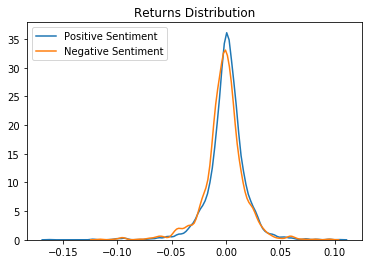

In [10]:
### First visual - histogram of returns split by sentiment =>0 and <0

positive = all_df[all_df["sentiment_txtblob"] >= 0]
negative = all_df[all_df["sentiment_txtblob"] < 0]

sns.kdeplot(positive["Return"], label="Positive Sentiment")
sns.kdeplot(negative["Return"], label = "Negative Sentiment").set_title("Returns Distribution")

C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Returns Distribution')

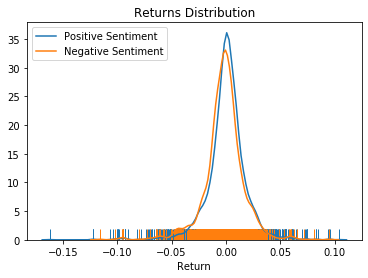

In [11]:
sns.distplot(positive["Return"], label="Positive Sentiment", hist=False, rug=True)
sns.distplot(negative["Return"], label = "Negative Sentiment", hist=False, rug = True).set_title("Returns Distribution")

C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Returns Distribution')

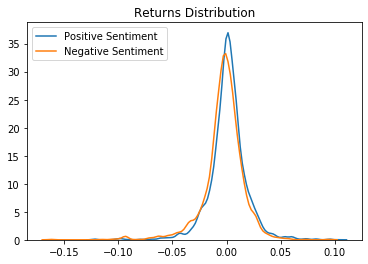

In [12]:
positive = all_df[all_df["compound_sentiment_nltk"] >= 0]
negative = all_df[all_df["compound_sentiment_nltk"] < 0]

sns.kdeplot(positive["Return"], label="Positive Sentiment")
sns.kdeplot(negative["Return"], label = "Negative Sentiment").set_title("Returns Distribution")

C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Returns Distribution')

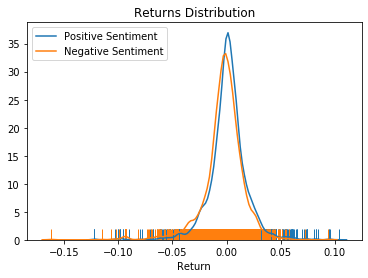

In [13]:
sns.distplot(positive["Return"], label="Positive Sentiment", hist=False, rug=True)
sns.distplot(negative["Return"], label = "Negative Sentiment", hist=False, rug = True).set_title("Returns Distribution")

C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Word Count Distribution')

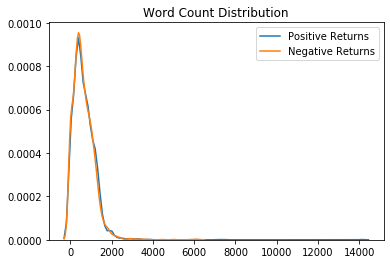

In [14]:
rtns_positive = all_df[all_df["Return"] >= 0]
rtns_negative = all_df[all_df["Return"] < 0]

sns.kdeplot(rtns_positive["word_count"], label="Positive Returns")
sns.kdeplot(rtns_negative["word_count"], label = "Negative Returns").set_title("Word Count Distribution")

C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Log Word Count Distribution')

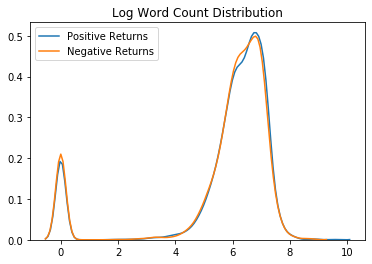

In [15]:
pos_log_wc = np.log(pd.Series(map(lambda x: float(x), rtns_positive["word_count"])) + 1)
neg_log_wc = np.log(pd.Series(map(lambda x: float(x), rtns_negative["word_count"])) + 1)


sns.kdeplot(pos_log_wc, label="Positive Returns")
sns.kdeplot(neg_log_wc, label = "Negative Returns").set_title("Log Word Count Distribution")

In [16]:
type(rtns_positive["word_count"])

pandas.core.series.Series

In [17]:

pd.Series(map(lambda x: float(x), rtns_positive["word_count"]))

0        449.0
1        294.0
2        290.0
3        307.0
4        301.0
5          0.0
6       1284.0
7        204.0
8        787.0
9          0.0
10         0.0
11         0.0
12       467.0
13       836.0
14       306.0
15       442.0
16        35.0
17       336.0
18      1216.0
19      1260.0
20         0.0
21       168.0
22       440.0
23       166.0
24       537.0
25       346.0
26       298.0
27       194.0
28       398.0
29       226.0
         ...  
3328     758.0
3329     502.0
3330    1033.0
3331     168.0
3332    1846.0
3333    1103.0
3334     965.0
3335     993.0
3336    1211.0
3337     851.0
3338     844.0
3339     555.0
3340    1124.0
3341    1139.0
3342     450.0
3343     605.0
3344     818.0
3345     974.0
3346     131.0
3347    1090.0
3348     401.0
3349     708.0
3350     856.0
3351     538.0
3352    1221.0
3353     165.0
3354    1188.0
3355    1367.0
3356    1128.0
3357    1074.0
Length: 3358, dtype: float64

Text(0.5, 1.0, 'Txtblb Sentiment Distribution Split by Returns Label (1 or -1)')

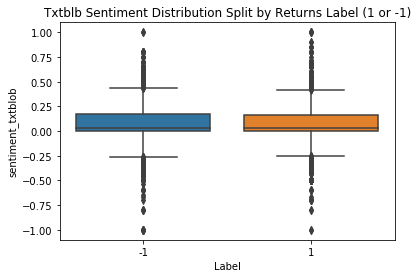

In [18]:
sns.boxplot(x="Label", y="sentiment_txtblob", data=all_df).set_title("Txtblb Sentiment Distribution Split by Returns Label (1 or -1)")

Text(0.5, 1.0, 'NLTK Sentiment Distribution Split by Returns Label (1 or -1)')

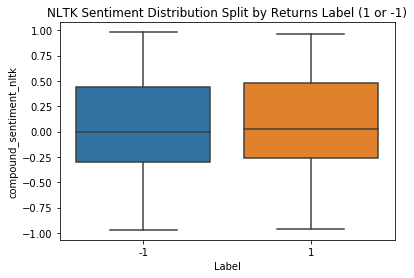

In [19]:
sns.boxplot(x="Label", y="compound_sentiment_nltk", data=all_df).set_title("NLTK Sentiment Distribution Split by Returns Label (1 or -1)")

C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Textblob vs nltk sentiment correl')

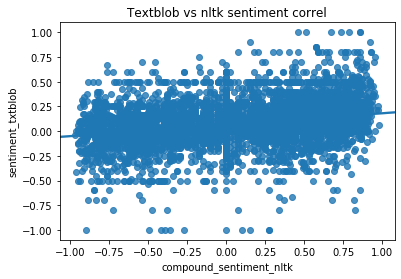

In [20]:
sns.regplot(x="compound_sentiment_nltk", y="sentiment_txtblob", data=all_df).set_title("Textblob vs nltk sentiment correl")


C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Textblob vs nltk sentiment correl')

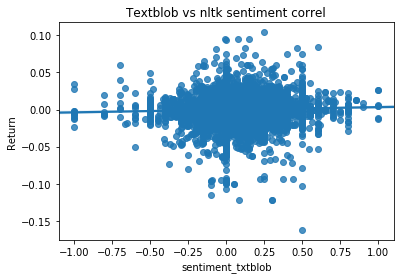

In [21]:
sns.regplot(x="sentiment_txtblob", y="Return", data=all_df).set_title("Textblob vs nltk sentiment correl")

C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Textblob vs nltk sentiment correl')

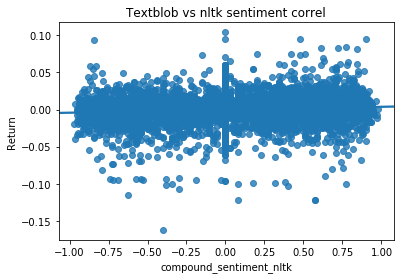

In [22]:
sns.regplot(x="compound_sentiment_nltk", y="Return", data=all_df).set_title("Textblob vs nltk sentiment correl")

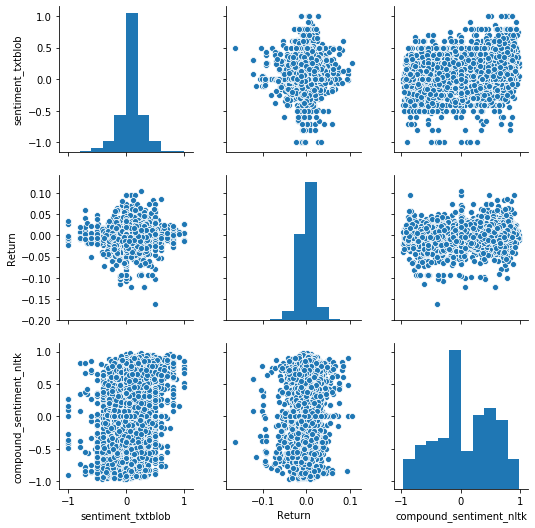

In [23]:
sns.pairplot(all_df[["sentiment_txtblob", "Return", "compound_sentiment_nltk"]])

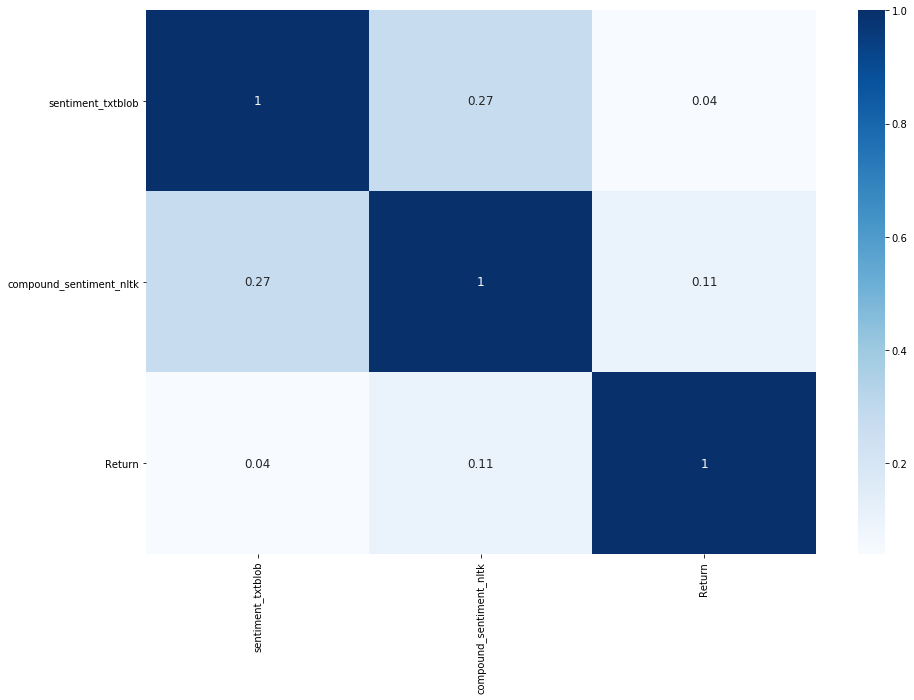

In [24]:

corr = all_df.corr()
sns.heatmap(corr, cmap= "Blues", xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(15,10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

## Apple Dataset Specific

C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Returns Distribution')

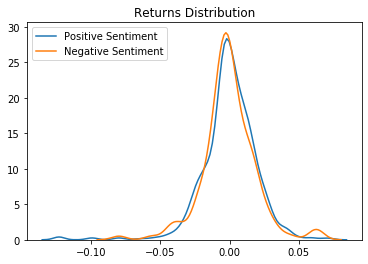

In [25]:
positive = apple_df[apple_df["sentiment_txtblob"] >= 0]
negative = apple_df[apple_df["sentiment_txtblob"] < 0]

sns.kdeplot(positive["Return"], label="Positive Sentiment")
sns.kdeplot(negative["Return"], label = "Negative Sentiment").set_title("Returns Distribution")

C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Returns Distribution')

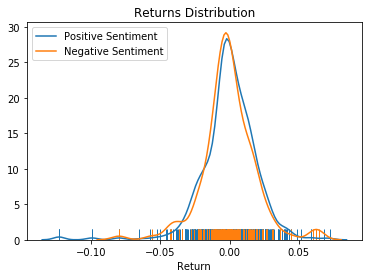

In [26]:
sns.distplot(positive["Return"], label="Positive Sentiment", hist=False, rug=True)
sns.distplot(negative["Return"], label = "Negative Sentiment", hist=False, rug = True).set_title("Returns Distribution")

In [27]:
all_df.head()

,word_count,sentiment_txtblob,compound_sentiment_nltk,Label,Return
0,449,0.025000,0.0000,1,0.003229
1,440,0.100000,-0.4019,-1,-0.015906
2,404,0.000000,0.0000,-1,-0.015906
3,294,0.500000,0.0000,1,0.045738
4,290,0.466667,0.8720,1,0.028403


In [28]:
apple_df.head()

,Date,word_count,text_label,Label,Return,text_lem_lst,text_lem_str,sentiment_txtblob,positivity_sentiment_nltk,compound_sentiment_nltk,negativity_sentiment_nltk,neutral_sentiment_nltk
0,2010-01-05,449,"Apple Buys Quattro, an Ad Firm. While Google i...",1,0.002029,"['Apple', 'Buys', 'Quattro,', 'an', 'Ad', 'Fir...","Apple Buys Quattro, an Ad Firm. While Google ...",0.025000,0.000,0.0000,0.000,1.000
1,2010-01-06,440,"Apple Buys Quattro, an Ad Firm. Apple encroach...",-1,-0.015906,"['Apple', 'Buys', 'Quattro,', 'an', 'Ad', 'Fir...","Apple Buys Quattro, an Ad Firm. Apple encroac...",0.100000,0.000,-0.4019,0.072,0.928
2,2010-01-06,404,Putting the “i” in Apple. iSlate has plenty of...,-1,-0.015906,"['Putting', 'the', '“i”', 'in', 'Apple.', 'iSl...",Putting the “i” in Apple. iSlate have plenty ...,0.000000,0.000,0.0000,0.000,1.000
3,2010-01-19,294,Reading Apple’s Tea Leaves. Take one splatter-...,1,0.044538,"['Reading', 'Apple’s', 'Tea', 'Leaves.', 'Take...",Reading Apple’s Tea Leaves. Take one splatter...,0.500000,0.000,0.0000,0.000,1.000
4,2010-01-25,290,Laptop Sales Help Apple Top Forecasts. The con...,1,0.027203,"['Laptop', 'Sales', 'Help', 'Apple', 'Top', 'F...",Laptop Sales Help Apple Top Forecasts. The co...,0.466667,0.391,0.8720,0.000,0.609


C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Returns Distribution')

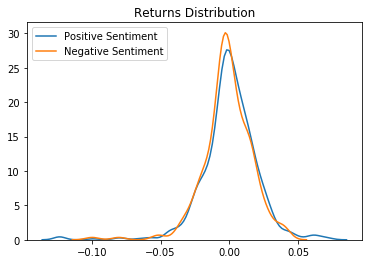

In [29]:
positive = apple_df[apple_df["compound_sentiment_nltk"] >= 0]
negative = apple_df[apple_df["compound_sentiment_nltk"] < 0]

sns.kdeplot(positive["Return"], label="Positive Sentiment")
sns.kdeplot(negative["Return"], label = "Negative Sentiment").set_title("Returns Distribution")

C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Returns Distribution')

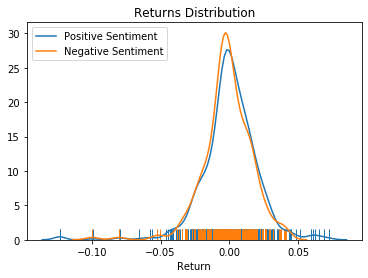

In [30]:
sns.distplot(positive["Return"], label="Positive Sentiment", hist=False, rug=True)
sns.distplot(negative["Return"], label = "Negative Sentiment", hist=False, rug = True).set_title("Returns Distribution")

C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Word Count Distribution')

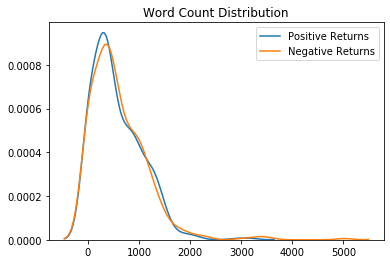

In [31]:
rtns_positive = apple_df[apple_df["Return"] >= 0]
rtns_negative = apple_df[apple_df["Return"] < 0]

sns.kdeplot(rtns_positive["word_count"], label="Positive Returns")
sns.kdeplot(rtns_negative["word_count"], label = "Negative Returns").set_title("Word Count Distribution")

Text(0.5, 1.0, 'Sentiment Distribution Split by Returns Label (1 or -1)')

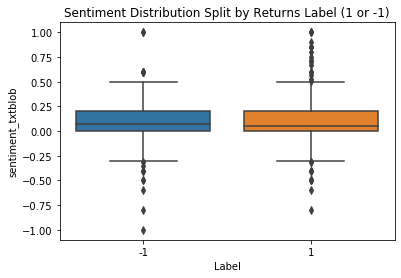

In [32]:
sns.boxplot(x="Label", y="sentiment_txtblob", data=apple_df).set_title("Sentiment Distribution Split by Returns Label (1 or -1)")

Text(0.5, 1.0, 'Sentiment Distribution Split by Returns Label (1 or -1)')

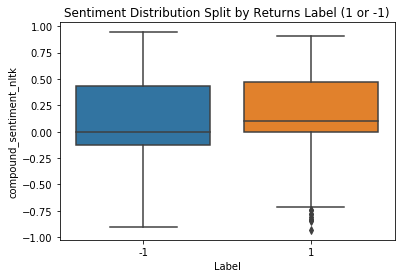

In [33]:
sns.boxplot(x="Label", y="compound_sentiment_nltk", data=apple_df).set_title("Sentiment Distribution Split by Returns Label (1 or -1)")

C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Textblob vs nltk sentiment correl')

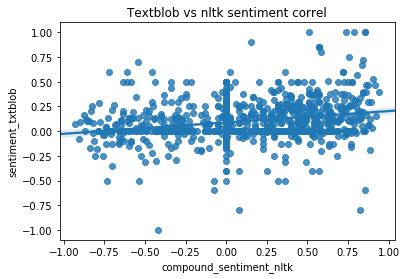

In [34]:
sns.regplot(x="compound_sentiment_nltk", y="sentiment_txtblob", data=apple_df).set_title("Textblob vs nltk sentiment correl")


C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Textblob vs Rtns correl')

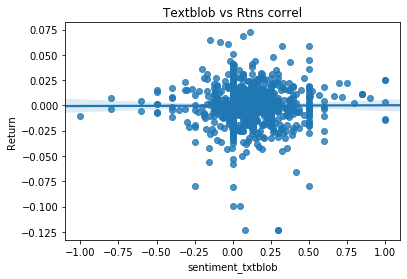

In [35]:
sns.regplot(x="sentiment_txtblob", y="Return", data=apple_df).set_title("Textblob vs Rtns correl")


C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'nltk sentiment vs Rtns correl')

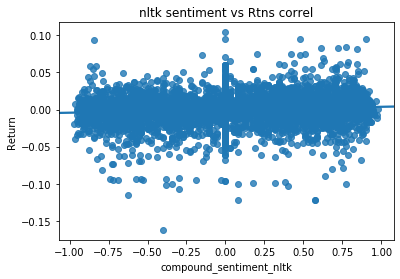

In [36]:
sns.regplot(x="compound_sentiment_nltk", y="Return", data=all_df).set_title("nltk sentiment vs Rtns correl")

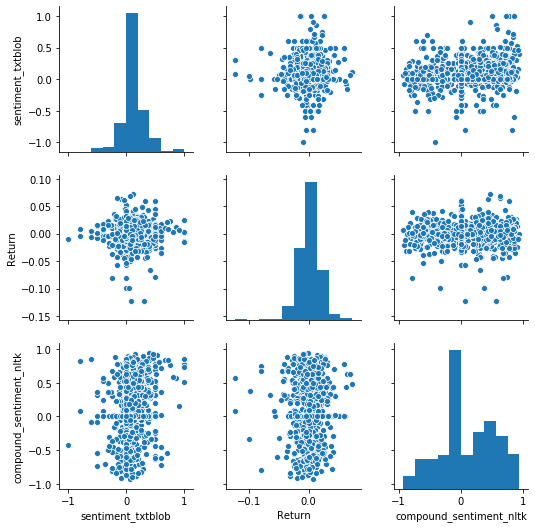

In [37]:
sns.pairplot(apple_df[["sentiment_txtblob", "Return", "compound_sentiment_nltk"]])

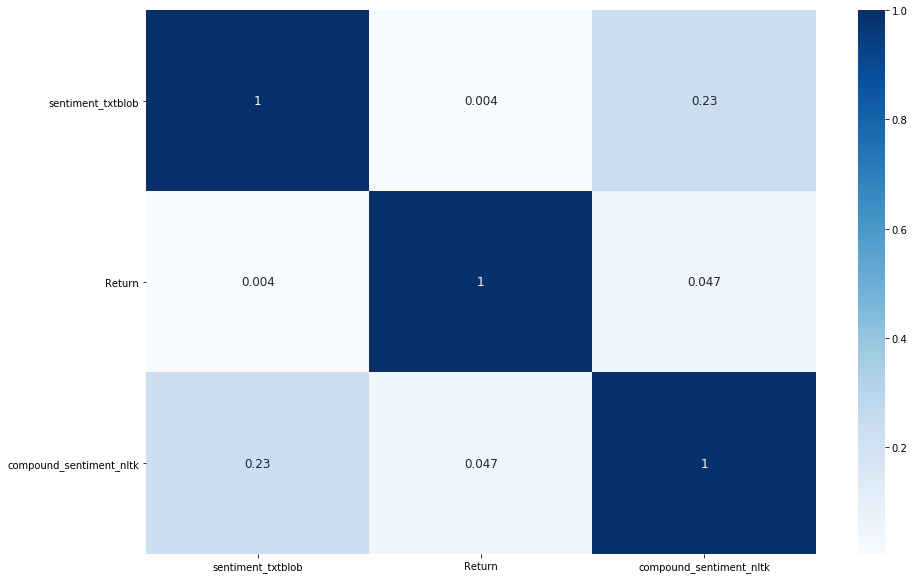

In [38]:
corr = apple_df[["sentiment_txtblob", "Return", "compound_sentiment_nltk"]].corr()
sns.heatmap(corr, cmap= "Blues", xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(15,10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

C:\Users\ksjag\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ksjag\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


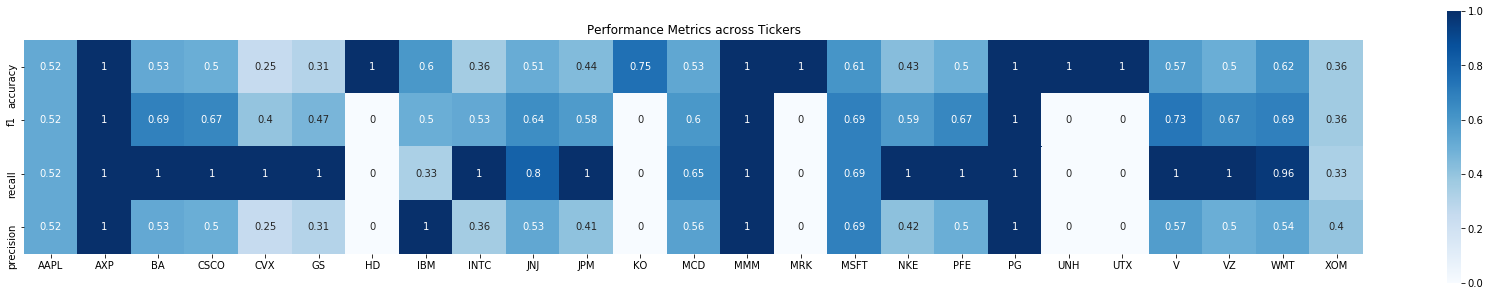

In [49]:


performance = {}
for ticker in sorted(tickers):
    #print(ticker)
    if ticker in ["DOW", "DIS", "TRV", "CAT", "WBA"]: continue
    
    this_df = pd.read_csv("../../Processed Data/Financial News/" + ticker + ".csv")[["Date", "Label"]]
    pred_df = pd.read_csv("../../Predictions/Financial News/" + ticker + "_test.csv")
    
    df_test = this_df[this_df["Date"] >= "2018-01-01"]
    df_test.reset_index(drop=True, inplace=True)

    pred_df = pred_df
    pred_df.reset_index(inplace=True, drop=True)

    merged = df_test.merge(pred_df, how="left", on="Date")
    
    if(len(merged)) < 5:
        merged = merged.append(merged)
    
    sub_y_test = merged["Label"]
    sub_y_pred = merged[ticker]
    
    if (len(sub_y_pred[sub_y_pred == sub_y_test])/len(sub_y_pred)) < 0.1:
        sub_y_test = sub_y_test * -1
    
    #roc_auc = roc_auc_score(sub_y_test, sub_y_pred)
    acc = accuracy_score(sub_y_test, sub_y_pred)
    f1 = f1_score(sub_y_test, sub_y_pred)
    recall = recall_score(sub_y_test, sub_y_pred)
    precision = precision_score(sub_y_test, sub_y_pred)
    
    performance[ticker] = [acc, f1, recall, precision]

    metrics_df = pd.DataFrame(performance).T

    metrics_df = metrics_df.rename(columns={0:"accuracy", 1:"f1", 2:"recall", 3:"precision"})

plt.figure(figsize=(30,5))
sns.heatmap(metrics_df.T, square=True,annot=True,cmap="Blues", linecolor='white')
plt.title('Performance Metrics across Tickers')
plt.show()